<a href="https://colab.research.google.com/github/rockey1006/Variational-Autoencoders/blob/master/VAE%2BSmile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Install facenet

In [1]:
import warnings
warnings.filterwarnings("ignore")
! git clone https://github.com/rockey1006/facenet-vae.git



Cloning into 'facenet-vae'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.


In [2]:
!git clone https://github.com/rockey1006/facenet.git

Cloning into 'facenet'...
remote: Enumerating objects: 3149, done.
remote: Total 3149 (delta 0), reused 0 (delta 0), pack-reused 3149
Receiving objects: 100% (3149/3149), 2.94 MiB | 4.97 MiB/s, done.
Resolving deltas: 100% (2231/2231), done.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install facenet

     |████████████████████████████████| 2.0MB 7.7MB/s 


#Transfer trained model

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/model.ckpt.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/content/facenet/model.ckpt')

In [0]:
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/smile3.ckpt.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('/content/facenet/smile1.ckpt')

In [7]:
%matplotlib inline
%pylab inline


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


In [8]:
import tensorflow as tf
import sys
import argparse
import importlib
import facenet
import os
import numpy as np
import h5py
import math
from scipy import misc

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
np.random.seed(None)
pylab.rcParams['figure.figsize'] = (10, 6)

In [0]:
from facenet.src.generative.models import dfc_vae

In [0]:
img_mean = np.array([134.10714722, 102.52040863, 87.15436554])
img_stddev = np.sqrt(np.array([3941.30175781, 2856.94287109, 2519.35791016]))

latentVarSize = 100
vae_def = dfc_vae
vae = vae_def.Vae(latentVarSize)
gen_image_size = vae.get_image_size()

In [0]:
with tf.Graph().as_default():

    images = tf.placeholder(tf.float32, shape=(None, gen_image_size,gen_image_size,3), name='input')

    # Normalize
    images_norm = (images-img_mean) / img_stddev

    # Resize to appropriate size for the encoder 
    images_norm_resize = tf.image.resize_images(images_norm, (gen_image_size,gen_image_size))

    # Create encoder network
    mean, log_variance = vae.encoder(images_norm_resize, True)

    epsilon = tf.random_normal((tf.shape(mean)[0], latentVarSize))
    std = tf.exp(log_variance/2)
    latent_var = mean + epsilon * std

    # Create decoder
    reconstructed_norm = vae.decoder(latent_var, False)

    # Un-normalize
    reconstructed = (reconstructed_norm*img_stddev) + img_mean

    # Create a saver
    saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=3)

    # Start running operations on the Graph
    gpu_memory_fraction = 1.0
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(coord=coord, sess=sess)

In [0]:
import facenet.src.facenet as facenet


In [0]:
import imageio
import imageio.core.util
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning


In [24]:
with sess.as_default():
    
    # Load checkpoint
    vae_checkpoint = os.path.expanduser('/content/facenet/model.ckpt/model.ckpt-50000')
    print('Restoring VAE checkpoint: %s' % vae_checkpoint)
    saver.restore(sess, vae_checkpoint)
    
    # Load attribute file
    filename = os.path.expanduser('/content/facenet/smile1.ckpt/attribute_vectors.h5')
    with h5py.File(filename,'r') as f:
        latent_vars = np.array(f.get('latent_vars'))
        attributes = np.array(f.get('attributes'))
        #fields = np.array(f.get('fields'))
        attribute_vectors = np.array(f.get('attribute_vectors'))

    attribute_index = 31
    image_indices = [8]
    nrof_images = len(image_indices)
    nrof_interp_steps = 2
    sweep_latent_var = np.zeros((nrof_interp_steps * nrof_images, latentVarSize), np.float32)
    for j in range(nrof_images):
        image_index = image_indices[j]
        idx = np.argwhere(attributes[:, attribute_index] == -1)[image_index, 0]
        initialGenes = latent_vars[idx,:]
        for i in range(nrof_interp_steps):
            sweep_latent_var[i+nrof_interp_steps*j,:] = latent_vars[idx,:] + 5.0*i/nrof_interp_steps*attribute_vectors[attribute_index,:]
            print (sweep_latent_var.shape)
    recon = sess.run(reconstructed, feed_dict={latent_var:sweep_latent_var})

    for i in range(recon.shape[0]):           
        img = facenet.put_images_on_grid(recon[i : i + 1], shape=(1, 1))
        image_filename = os.path.expanduser('/content/facenet/add_smile') + str(i) + '.png'
        print('Writing generated image to %s' % image_filename)
        imageio.imwrite(image_filename, img)



Restoring VAE checkpoint: /content/facenet/model.ckpt/model.ckpt-50000
(2, 100)
(2, 100)
Writing generated image to /content/facenet/add_smile0.png
Writing generated image to /content/facenet/add_smile1.png


#2.Generate original and target Imgaes and take initial genes¶


In [0]:
from PIL import Image
new_image = Image.open('/content/original.png').convert("RGB")
new_image = new_image.resize((70, 70))
new_image.save('/content/original1.png')

(70, 70, 3)


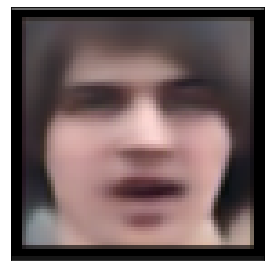

In [27]:
originalImage = imageio.imread('/content/original1.png')
plt.subplot(1, 2, 1)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.imshow(originalImage)
print(originalImage.shape)



In [0]:
from PIL import Image

new_image = Image.open('/content/target.png').convert("RGB")

new_image = new_image.resize((70, 70))

new_image.save('/content/target1.png')


(70, 70, 3)


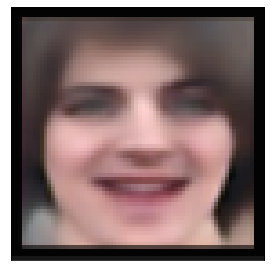

In [29]:
targetImage = imageio.imread('/content/target1.png')
plt.subplot(1, 2, 1)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.imshow(targetImage)
print(targetImage.shape)

In [0]:
attribute_index = 31
image_index = 10
nrof_images = len(image_indices)
nrof_interp_steps = 1

#3.Genetic learning helpers


In [0]:
bestGenes = initialGenes
def evaluateFitness(solution):
    return np.log(np.sum(np.abs(solution - targetImage)))

def generateTwoIndices(n):
    
    """
        Generates two random integers in [0, n) such 
        that first < second
        
    """
    
    first, second = 0, 0
    while first == second:
        first  = int(np.random.uniform() * n)
        second = int(np.random.uniform() * n)
    
    if first > second:
        first, second = second, first

    return first, second
    # Load attribute file
filename = os.path.expanduser('/content/facenet/smile1.ckpt/attribute_vectors.h5')
with h5py.File(filename,'r') as f:
    latent_vars = np.array(f.get('latent_vars'))
    attributes = np.array(f.get('attributes'))
    attribute_vectors = np.array(f.get('attribute_vectors'))

In [0]:
def crossover(space1, space2):

    first, second = generateTwoIndices(len(space1))
    crossover = np.zeros_like(space1)   
    
    crossover[ : first] = space1[ : first]
    crossover[first : second] = space2[first : second]
    crossover[second : ] = space1[second : ]

    return crossover

def mutate(space):
    
    """
        Introduces mutation in a given solution
    """
    
    randIndex = int(np.random.uniform() * space.shape[0])
    space[randIndex] += (np.random.uniform(-1., 1.))
    return space

In [0]:
def localSearch(latentSpace):
    
    newLatentSpace = [latentSpace]
    
    for i in range(latentSpace.shape[0]):
        tempLatentSpace = latentSpace
        tempLatentSpace[i] += np.random.uniform()
        newLatentSpace.append(tempLatentSpace)

    for i in range(latentSpace.shape[0]):
        tempLatentSpace = latentSpace
        tempLatentSpace[i] -= np.random.uniform()
        newLatentSpace.append(tempLatentSpace)

    newLatentSpace = np.array(newLatentSpace)

    with sess.as_default():
        # Load checkpoint
        vae_checkpoint = os.path.expanduser('/content/facenet/model.ckpt/model.ckpt-50000')
        saver.restore(sess, vae_checkpoint)
        recon = sess.run(reconstructed, feed_dict={latent_var : newLatentSpace})

    scores = []
    
    # Select top solution based on evaluation function
    for i in range(newLatentSpace.shape[0]):
        img = facenet.put_images_on_grid(recon[i : i + 1], shape=(1, 1))
        imageio.imwrite('temp.png', img)
        img = imageio.imread('temp.png')
        scores.append(evaluateFitness(img))
       
    scores = np.array(scores)
    return newLatentSpace[scores.argsort()[0]]


In [34]:
print(img.shape)

(70, 70, 3)


In [0]:
generationMins = []
generationLatentSpace = []

maxIter = 100
currIter = 0
generationSize = 65
top = 10

latentSpace = np.zeros((generationSize, latentVarSize), np.float32)
for i in range(generationSize):
    latentSpace[i, :] = initialGenes + np.random.uniform(-1., 1., (100,)) * 5


Iteration : 0 Best score : 14.11010071456357


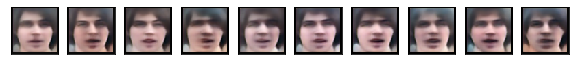

Iteration : 1 Best score : 13.855431026231829


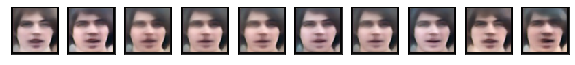

Iteration : 2 Best score : 13.693097696184072


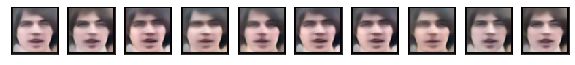

Iteration : 3 Best score : 13.501199733145901


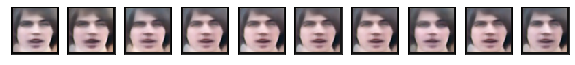

Iteration : 4 Best score : 13.47118052960202


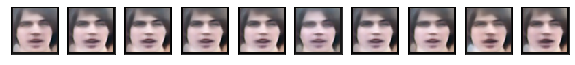

Iteration : 5 Best score : 13.438971041953682


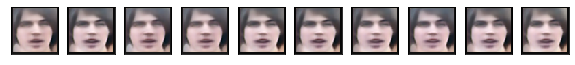

Iteration : 6 Best score : 13.431401282069492


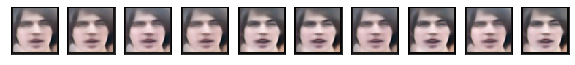

Iteration : 7 Best score : 13.380032019286766


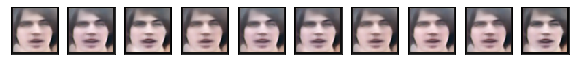

Iteration : 8 Best score : 13.378012840274797


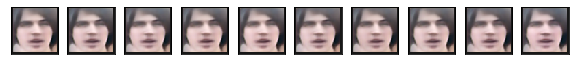

Iteration : 9 Best score : 13.356821872618111


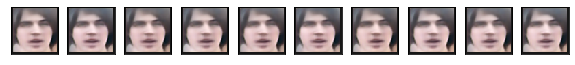

Iteration : 10 Best score : 13.343593098513265


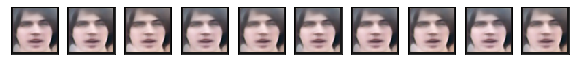

Iteration : 11 Best score : 13.336621167010504


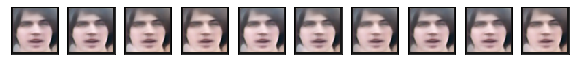

Iteration : 12 Best score : 13.320062753775922


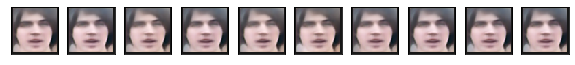

Iteration : 13 Best score : 13.300015717016679


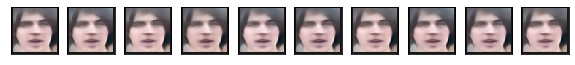

Iteration : 14 Best score : 13.297603251503412


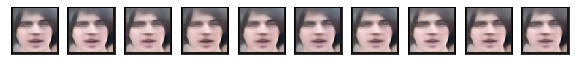

Iteration : 15 Best score : 13.254392892775613


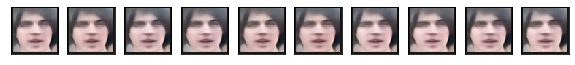

Iteration : 16 Best score : 13.249785144216622


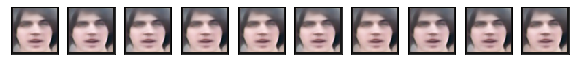

Iteration : 17 Best score : 13.226058306743047


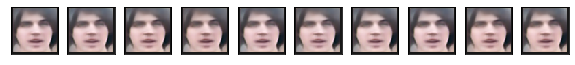

Iteration : 18 Best score : 13.172993752109173


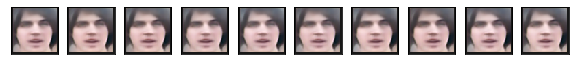

Iteration : 19 Best score : 13.148473521407514


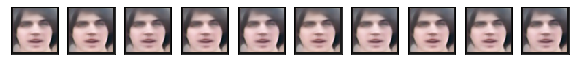

Iteration : 20 Best score : 13.145667709706238


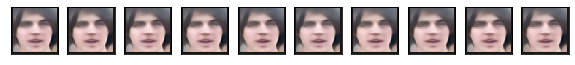

Iteration : 21 Best score : 13.109594197326109


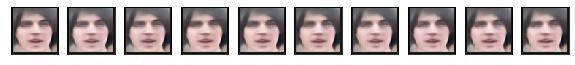

Iteration : 22 Best score : 13.08795618067035


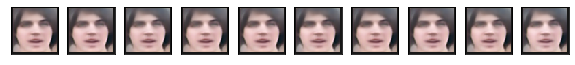

Iteration : 23 Best score : 13.094019456895033


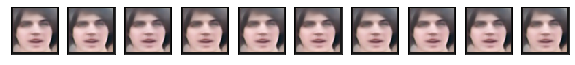

Iteration : 24 Best score : 13.056082539313707


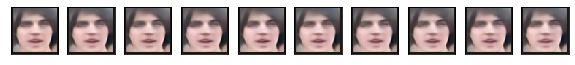

Iteration : 25 Best score : 13.02177810875119


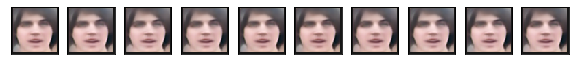

Iteration : 26 Best score : 13.03802914094669


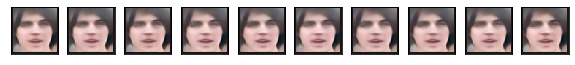

Iteration : 27 Best score : 13.026391979043188


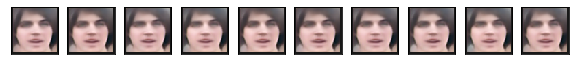

Iteration : 28 Best score : 12.999881569788965


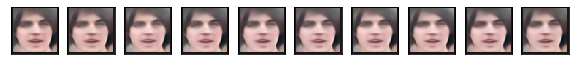

Iteration : 29 Best score : 12.978370597645334


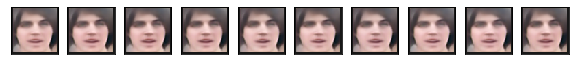

Iteration : 30 Best score : 12.967943327967001


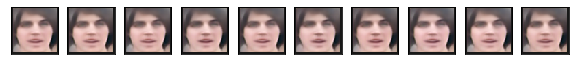

Iteration : 31 Best score : 12.94351657664721


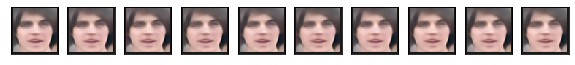

Iteration : 32 Best score : 12.9491545730699


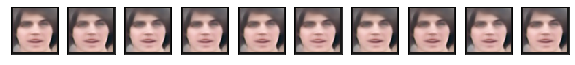

Iteration : 33 Best score : 12.942138022044205


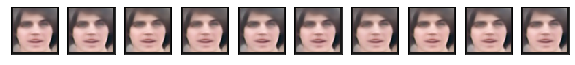

Iteration : 34 Best score : 12.933959359894017


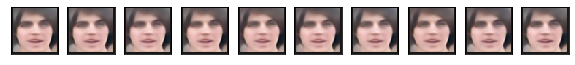

Iteration : 35 Best score : 12.94047692593832


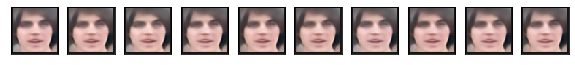

Iteration : 36 Best score : 12.933802395820354


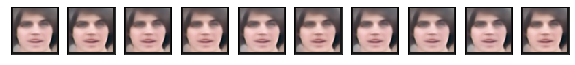

Iteration : 37 Best score : 12.89935481697844


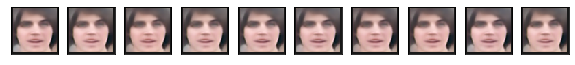

Iteration : 38 Best score : 12.887541903809865


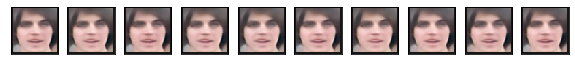

Iteration : 39 Best score : 12.878718604833992


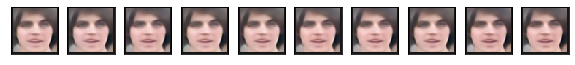

Iteration : 40 Best score : 12.867847831007515


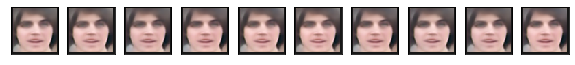

Iteration : 41 Best score : 12.867076211096533


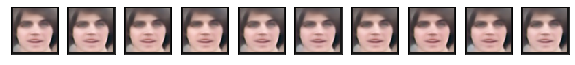

Iteration : 42 Best score : 12.841524503434542


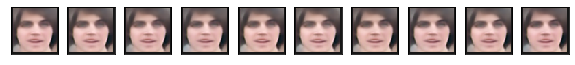

Iteration : 43 Best score : 12.80463163558878


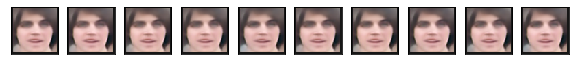

Iteration : 44 Best score : 12.838928273799871


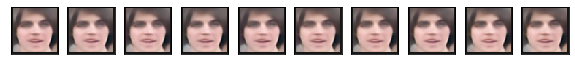

Iteration : 45 Best score : 12.829336379587506


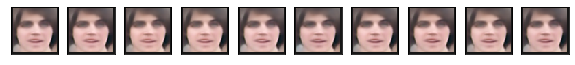

Iteration : 46 Best score : 12.806460141007197


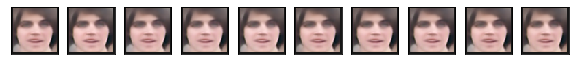

Iteration : 47 Best score : 12.826866851488433


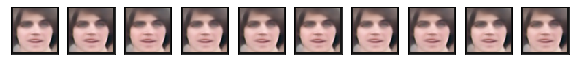

Iteration : 48 Best score : 12.788045219089703


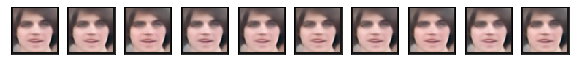

Iteration : 49 Best score : 12.789722989863224


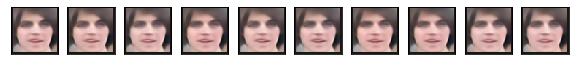

Iteration : 50 Best score : 12.804472238001393


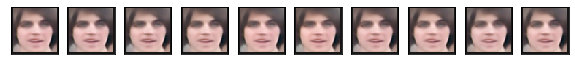

Iteration : 51 Best score : 12.800683196891312


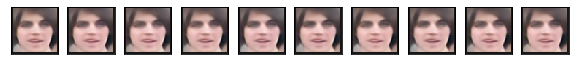

Iteration : 52 Best score : 12.781277715281954


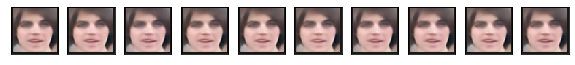

Iteration : 53 Best score : 12.766371057567598


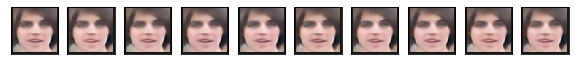

Iteration : 54 Best score : 12.779982921578407


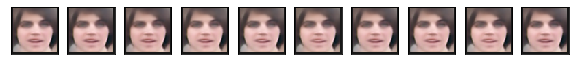

Iteration : 55 Best score : 12.75853433237268


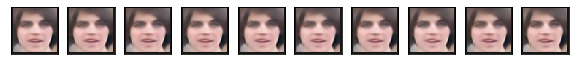

Iteration : 56 Best score : 12.757094468047086


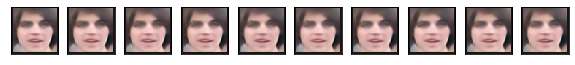

Iteration : 57 Best score : 12.761060598680906


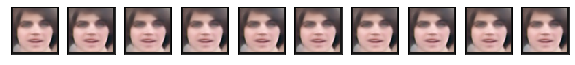

Iteration : 58 Best score : 12.771426226516592


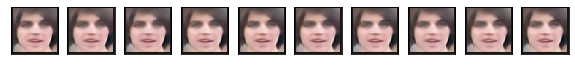

Iteration : 59 Best score : 12.7478386410028


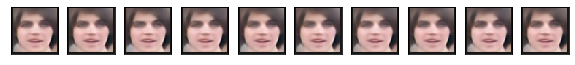

Iteration : 60 Best score : 12.768652607386732


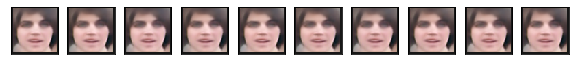

Iteration : 61 Best score : 12.768307856921394


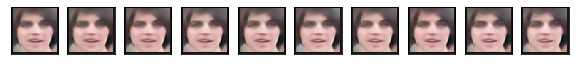

Iteration : 62 Best score : 12.732592468547802


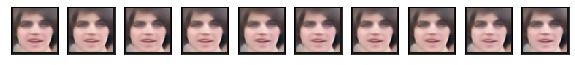

Iteration : 63 Best score : 12.744035695770144


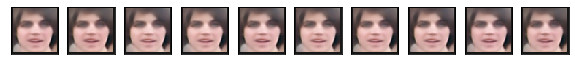

Iteration : 64 Best score : 12.762268305776605


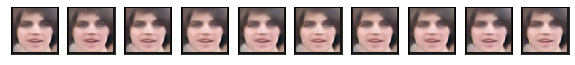

Iteration : 65 Best score : 12.747530281849217


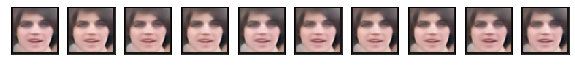

Iteration : 66 Best score : 12.74399481938034


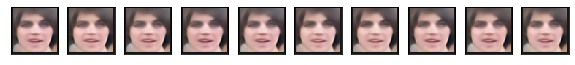

Iteration : 67 Best score : 12.750571894998695


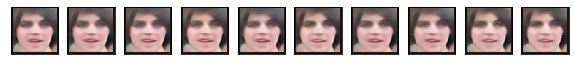

Iteration : 68 Best score : 12.729519288111046


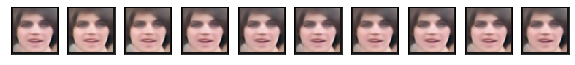

Iteration : 69 Best score : 12.73234731585041


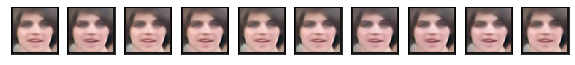

Iteration : 70 Best score : 12.707147888451662


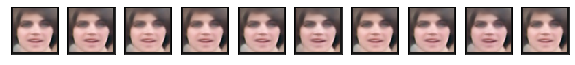

Iteration : 71 Best score : 12.69055840072431


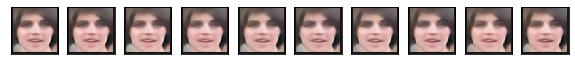

Iteration : 72 Best score : 12.695667482665758


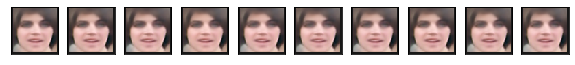

In [0]:
while currIter < maxIter:

    # Generate Generation
    with sess.as_default():
        # Load checkpoint
        vae_checkpoint = os.path.expanduser('/content/facenet/model.ckpt/model.ckpt-50000')
        saver.restore(sess, vae_checkpoint)
        recon = sess.run(reconstructed, feed_dict={latent_var : latentSpace})

    scores = []
    
    # Select top 10 solutions based on evaluation function
    for i in range(generationSize):
        img = facenet.put_images_on_grid(recon[i : i + 1], shape=(1, 1))
        imageio.imwrite('temp.png', img)
        img = imageio.imread('temp.png')
        scores.append(evaluateFitness(img))
       
    topTenIndices = np.array(scores).argsort()[: top]
    generationMins.append(scores[topTenIndices[0]])
    generationLatentSpace.append(latentSpace[topTenIndices[0] : topTenIndices[0] + 1].flatten().tolist())
    
    print ("Iteration : " + str(currIter) + " Best score : " + str(scores[topTenIndices[0]]))
    for i in range(top):
        img = facenet.put_images_on_grid(recon[topTenIndices[i] : topTenIndices[i] + 1], shape=(1, 1))
        imageio.imwrite('temp.png', img)
        img = imageio.imread('temp.png')
        plt.subplot(1, top, i + 1)
        plt.gca().xaxis.set_visible(False)
        plt.gca().yaxis.set_visible(False)
        plt.imshow(img)
    plt.show()
    
    newLatentSpace = []
    for ind in topTenIndices:
        newLatentSpace.append(latentSpace[ind])
    
    for i in range(10):
        for j in range(i, 10):
            newLatentSpace.append(crossover(newLatentSpace[i], newLatentSpace[j]))
    
    for i in range(10, 65):
        if np.random.uniform() > 0.25:
            newLatentSpace[i] = mutate(newLatentSpace[i])
    
    newLatentSpace = np.array(newLatentSpace)
    
    for i in range(65):
        newLatentSpace[i] = localSearch(newLatentSpace[i])

    latentSpace = np.array(newLatentSpace)

    currIter += 1